# Customer Analysis Notebook

## Online Retail Dataset Analysis

### Setup and Data Loading

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Plotting settings
warnings.filterwarnings('ignore')
%matplotlib inline

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Loading and Initial Inspection of Cleaned Data

In [3]:
# Load the cleaned dataset
df = pd.read_csv('../data/online_retail_cleaned.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\nSample of first few rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  int64  
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  int64  
 7   Country      397924 non-null  object 
 8   Year         397924 non-null  int64  
 9   Month        397924 non-null  int64  
 10  Day          397924 non-null  int64  
 11  Hour         397924 non-null  int64  
 12  TotalAmount  397924 non-null  float64
 13  IsOrder      397924 non-null  bool   
dtypes: bool(1), float64(2), int64(7), object(4)
memory usage: 39.8+ MB
None

Sample of first few rows:
   InvoiceNo StockCode                          Description  Quantity  \
0     5363

### Customer Purchase Frequency Analysis

Purchase Frequency Summary:
       CustomerID  purchase_count  customer_lifetime_days  total_spend  \
count    4339.000        4339.000                4339.000     4339.000   
mean    15299.937          91.709                 130.419     2053.793   
std      1721.890         228.793                 132.039     8988.248   
min     12346.000           1.000                   0.000        0.000   
25%     13812.500          17.000                   0.000      307.245   
50%     15299.000          41.000                  92.000      674.450   
75%     16778.500         100.000                 251.500     1661.640   
max     18287.000        7847.000                 373.000   280206.020   

       avg_days_between_purchases  
count                    4339.000  
mean                        2.814  
std                         7.076  
min                         0.000  
25%                         0.000  
50%                         1.050  
75%                         2.873  
max              

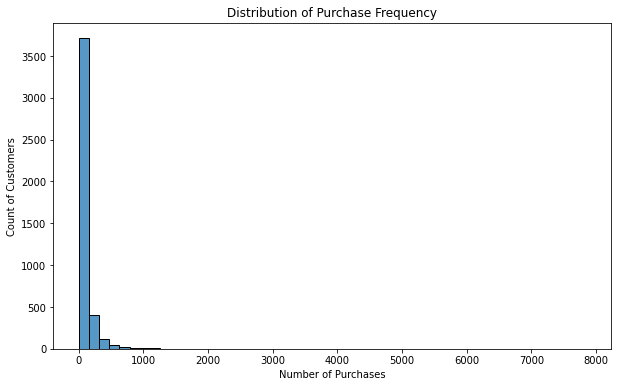

In [5]:
# Calculate purchase frequency metrics per customer
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Now calculate the frequency metrics
customer_frequency = df.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    'InvoiceDate': lambda x: (x.max() - x.min()).days,
    'TotalAmount': 'sum'
}).reset_index()

# Calculate average time between purchases
customer_frequency['avg_days_between_purchases'] = customer_frequency['InvoiceDate'] / \
                                                 customer_frequency['InvoiceNo']

# Add meaningful column names
customer_frequency.columns = ['CustomerID', 'purchase_count', 'customer_lifetime_days', 
                            'total_spend', 'avg_days_between_purchases']

# Calculate purchase frequency segments
customer_frequency['frequency_segment'] = pd.qcut(customer_frequency['purchase_count'], 
                                                q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Display summary statistics
print("Purchase Frequency Summary:")
print(customer_frequency.describe())

# Create frequency distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_frequency, x='purchase_count', bins=50)
plt.title('Distribution of Purchase Frequency')
plt.xlabel('Number of Purchases')
plt.ylabel('Count of Customers')
plt.show()

### Customer Revenue Analysis

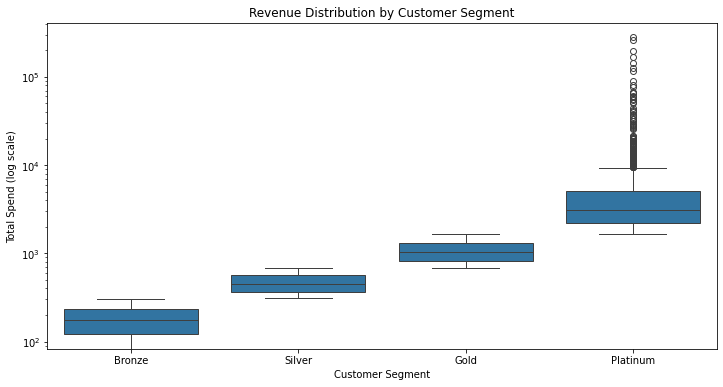

In [6]:
# Calculate key revenue metrics
revenue_metrics = customer_frequency.agg({
    'total_spend': ['mean', 'median', 'std', 'min', 'max'],
    'CustomerID': 'count'
}).round(2)

# Create revenue segments
customer_frequency['revenue_segment'] = pd.qcut(customer_frequency['total_spend'], 
                                              q=4, labels=['Bronze', 'Silver', 'Gold', 'Platinum'])

# Calculate revenue contribution by segment
revenue_by_segment = customer_frequency.groupby('revenue_segment').agg({
    'total_spend': 'sum',
    'CustomerID': 'count'
}).reset_index()

revenue_by_segment['revenue_percentage'] = (revenue_by_segment['total_spend'] / 
                                          revenue_by_segment['total_spend'].sum() * 100)

# Create revenue distribution visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=customer_frequency, x='revenue_segment', y='total_spend')
plt.title('Revenue Distribution by Customer Segment')
plt.yscale('log')
plt.xlabel('Customer Segment')
plt.ylabel('Total Spend (log scale)')
plt.show()

### Order Value Analysis

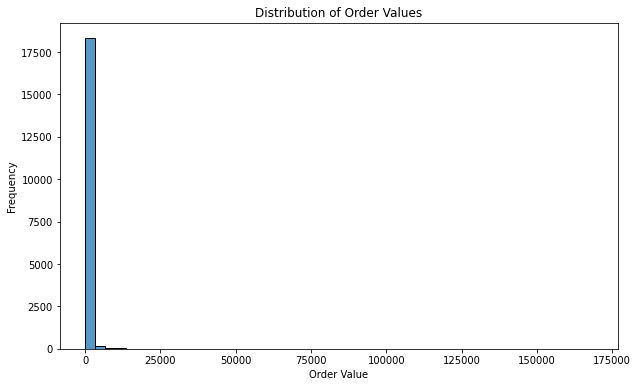


Order Value Summary Statistics:
       CustomerID  avg_order_value  median_order_value  std_order_value  \
count    4339.000         4339.000            4339.000         2845.000   
mean    15299.940          419.050             398.880          256.600   
std      1721.890         1796.320            1780.350         2302.000   
min     12346.000            0.000               0.000            0.000   
25%     13812.500          178.500             169.370           60.450   
50%     15299.000          293.690             289.700          119.190   
75%     16778.500          430.020             411.250          223.980   
max     18287.000        84236.250           84236.250       119123.950   

       order_count  
count     4339.000  
mean         4.270  
std          7.710  
min          1.000  
25%          1.000  
50%          2.000  
75%          5.000  
max        210.000  


In [7]:
# Calculate order value metrics per customer
order_values = df.groupby(['CustomerID', 'InvoiceNo'])['TotalAmount'].sum().reset_index()
order_value_stats = order_values.groupby('CustomerID').agg({
    'TotalAmount': ['mean', 'median', 'std', 'count']
}).reset_index()

order_value_stats.columns = ['CustomerID', 'avg_order_value', 'median_order_value', 
                           'std_order_value', 'order_count']

# Create order value distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(data=order_values, x='TotalAmount', bins=50)
plt.title('Distribution of Order Values')
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()

# Calculate and display summary statistics
print("\nOrder Value Summary Statistics:")
print(order_value_stats.describe().round(2))

### RFM Analysis and Customer Segmentation


Customer Segment Distribution:
Customer_Segment
Need Attention         1475
Champions               932
Loyal Customers         795
Potential Loyalists     574
At Risk                 563
Name: count, dtype: int64


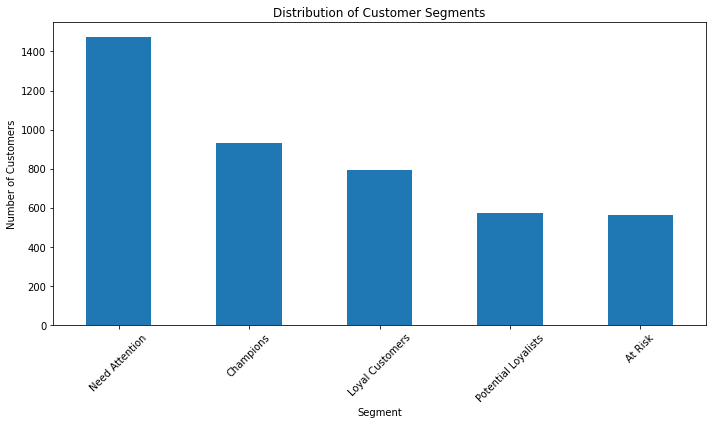

In [8]:
# Calculate Recency, Frequency, and Monetary metrics
current_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                    # Frequency
    'TotalAmount': 'sum'                                     # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'recency', 'frequency', 'monetary']

# Create RFM scores (1-5 scale)
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=[1,2,3,4,5])

# Calculate RFM Score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Define customer segments
def segment_customers(row):
    if row['R'] >= 4 and row['F'] >= 4 and row['M'] >= 4:
        return 'Champions'
    elif row['R'] >= 3 and row['F'] >= 3 and row['M'] >= 3:
        return 'Loyal Customers'
    elif row['R'] >= 3 and row['F'] >= 1 and row['M'] >= 2:
        return 'Potential Loyalists'
    elif row['R'] >= 2 and row['F'] <= 2 and row['M'] <= 2:
        return 'At Risk'
    else:
        return 'Need Attention'

rfm['Customer_Segment'] = rfm.apply(segment_customers, axis=1)

# Display segment distribution
segment_dist = rfm['Customer_Segment'].value_counts()
print("\nCustomer Segment Distribution:")
print(segment_dist)

# Visualize segments
plt.figure(figsize=(10, 6))
segment_dist.plot(kind='bar')
plt.title('Distribution of Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Export Analysis Results

In [9]:
# Combine all customer metrics
customer_analysis = pd.merge(customer_frequency, order_value_stats, on='CustomerID')
customer_analysis = pd.merge(customer_analysis, rfm[['CustomerID', 'Customer_Segment']], 
                           on='CustomerID')

# Export results to CSV
customer_analysis.to_csv('../data/customer_analysis_results.csv', index=False)

# Display final summary
print("\nCustomer Analysis Summary:")
print(f"Total number of customers analyzed: {len(customer_analysis)}")
print(f"Total revenue analyzed: ${customer_analysis['total_spend'].sum():,.2f}")
print("\nTop 5 customers by total spend:")
print(customer_analysis.nlargest(5, 'total_spend')[
    ['CustomerID', 'total_spend', 'purchase_count', 'Customer_Segment']
])


Customer Analysis Summary:
Total number of customers analyzed: 4339
Total revenue analyzed: $8,911,407.90

Top 5 customers by total spend:
      CustomerID  total_spend  purchase_count     Customer_Segment
1690       14646   280206.020            2080            Champions
4202       18102   259657.300             431            Champions
3729       17450   194550.790             337            Champions
3009       16446   168472.500               3  Potential Loyalists
1880       14911   143825.060            5677            Champions
